In [13]:
from collections import defaultdict
import json
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import os

In [14]:
# Uncomment for installations
# %pip install Jinja2

In [15]:
# Labels for charts, tables
models = {'electra-base-discriminator': 'ELECTRA', 'google/electra-base-discriminator': 'ELECTRA', 'roberta-base': 'RoBERTa', 'bert-base-uncased': 'BERT', 'distilbert-base-uncased': 'DistilBERT', 'elmo':'ELMo'}
datasets = {'kaggle_1000': 'Fake and Real News', 'fake_real_1000': 'Fake or Real News', 'liar_1000': 'Liar'}

### Visualization on **validation** set

#### Baseline

In [16]:
# Plot results baseline
path = "models/text-based"

res = defaultdict(dict)
x_values, y_values, hue_values = [], [], []

for root, dirs, files in os.walk(path):
    mets = []
    for file in files:

        # Look for trainer_state.json files for all models except for ELMo 
        if file == 'trainer_state.json':

            # PREPARE FOR CHART 
            x_values.append(models[model_name])
            hue_values.append(datasets[dataset])
            y_values.append(float("{:.2f}".format(f1)))

            # PREPARE FOR TABLE
            metrics = {}

            model_name = os.path.basename(os.path.dirname(os.path.dirname(root)))
            dataset = os.path.basename(os.path.dirname(root))
            trainer_state = os.path.join(root, file)

            with open(trainer_state) as f:
                data = json.load(f)

            f1 = data["log_history"][1]["eval_f1"]
            accuracy = data["log_history"][1]["eval_accuracy"]
            recall = data["log_history"][1]["eval_recall"]
            precision = data["log_history"][1]["eval_precision"]

            metrics['f1'] = "{:.2f}".format(f1)
            metrics['accuracy'] = "{:.2f}".format(accuracy)
            metrics['recall'] = "{:.2f}".format(recall)
            metrics['precision'] = "{:.2f}".format(precision)

            res[models[model_name]][datasets[dataset]] = metrics

        # Prepare doing the same for ELMo
        if 'elmo' in os.path.basename(os.path.dirname(root)):
            if file.endswith('.json'):
                mets.append(file)    
    
    # All ELMo from here
    mets_sorted = sorted(mets, key=lambda x: int(x.split(".")[0][-1]), reverse=True) # Only keep best EPOCH

    if mets_sorted:
        metrics = {}
        model_name = os.path.basename(os.path.dirname(root))
        dataset = os.path.basename(root)
        best_metric = mets_sorted[0]
        best_mets_file = os.path.join(root, best_metric)

        with open(best_mets_file) as f:
            data = json.load(f)
        
        f1 = data["best_validation_f1"]
        accuracy = data["best_validation_accuracy"]
        precision = data["best_validation_precision"]
        recall = data["best_validation_recall"]

        metrics['f1'] = "{:.2f}".format(f1)
        metrics['accuracy'] = "{:.2f}".format(accuracy)
        metrics['recall'] = "{:.2f}".format(recall)
        metrics['precision'] = "{:.2f}".format(precision)
        
        res[models[model_name]][datasets[dataset]] = metrics

        # PREPARE FOR CHART
        x_values.append(models[model_name])
        hue_values.append(datasets[dataset])   
        y_values.append(float("{:.2f}".format(f1)))

In [17]:
# F1 table only

index = res.keys()
values = []
cols = []

for model_name, d in res.items():
    tmp_cols = []

    for dataset, scores in d.items():
        for metric, score in scores.items():
            if metric == 'f1':
                values.append(score)
                tmp_cols.append((dataset, metric))

cols.append(tmp_cols)

# Flatten columns
cols = sum(cols, [])

multi_index = pd.MultiIndex.from_tuples(cols)

# Reshape the values
reshaped_values = np.array(values).reshape(-1, len(index))  

df = pd.DataFrame(reshaped_values, index=multi_index, columns=index)
df.T

,Fake and Real News,Fake or Real News,Liar
,f1,f1,f1
ELMo,0.97,0.67,0.56
ELECTRA,0.79,0.93,0.68
RoBERTa,0.53,0.78,0.91
BERT,0.94,0.67,0.75
DistilBERT,0.79,0.97,0.67


In [18]:
# Full table (A, P, R, F1)
# Create table with 2 level index (dataset, metric), columns are the models, values are the scores
index = res.keys()
values = []
cols = []

for model_name, d in res.items():
    tmp_cols = []

    for dataset, scores in d.items():
        for metric, score in scores.items():
            values.append(score)
            tmp_cols.append((dataset, metric))

cols.append(tmp_cols)

# Flatten columns
cols = sum(cols, [])

multi_index = pd.MultiIndex.from_tuples(cols)

# Reshape the values
reshaped_values = np.array(values).reshape(-1, len(index))  

df = pd.DataFrame(reshaped_values, index=multi_index, columns=index)
df.T

Fake and Real News                           Fake or Real News  \
                           f1 accuracy recall precision                f1   
ELMo                     0.97     0.80   0.40      0.94              0.67   
ELECTRA                  0.98     0.86   0.77      0.79              0.50   
RoBERTa                  1.00     0.73   0.94      0.80              1.00   
BERT                     0.94     0.53   0.96      0.68              0.50   
DistilBERT               0.79     0.64   0.94      0.95              0.93   

                                      Liar                            
           accuracy recall precision    f1 accuracy recall precision  
ELMo           0.96   0.71      0.50  0.56     0.52   1.00      0.90  
ELECTRA        0.88   0.87      0.97  0.66     1.00   0.84      0.67  
RoBERTa        1.00   0.67      0.98  0.39     0.51   0.75      0.50  
BERT           0.78   0.50      0.94  1.00     0.91   0.76      1.00  
DistilBERT     0.78   1.00      1.00  0.68     0.94   0.64      0.50

In [19]:
# For thesis
print(df.to_latex())

\begin{tabular}{lllllll}
\toprule
 &  & ELMo & ELECTRA & RoBERTa & BERT & DistilBERT \\
\midrule
\multirow[t]{4}{*}{Fake and Real News} & f1 & 0.97 & 0.98 & 1.00 & 0.94 & 0.79 \\
 & accuracy & 0.80 & 0.86 & 0.73 & 0.53 & 0.64 \\
 & recall & 0.40 & 0.77 & 0.94 & 0.96 & 0.94 \\
 & precision & 0.94 & 0.79 & 0.80 & 0.68 & 0.95 \\
\cline{1-7}
\multirow[t]{4}{*}{Fake or Real News} & f1 & 0.67 & 0.50 & 1.00 & 0.50 & 0.93 \\
 & accuracy & 0.96 & 0.88 & 1.00 & 0.78 & 0.78 \\
 & recall & 0.71 & 0.87 & 0.67 & 0.50 & 1.00 \\
 & precision & 0.50 & 0.97 & 0.98 & 0.94 & 1.00 \\
\cline{1-7}
\multirow[t]{4}{*}{Liar} & f1 & 0.56 & 0.66 & 0.39 & 1.00 & 0.68 \\
 & accuracy & 0.52 & 1.00 & 0.51 & 0.91 & 0.94 \\
 & recall & 1.00 & 0.84 & 0.75 & 0.76 & 0.64 \\
 & precision & 0.90 & 0.67 & 0.50 & 1.00 & 0.50 \\
\cline{1-7}
\bottomrule
\end{tabular}



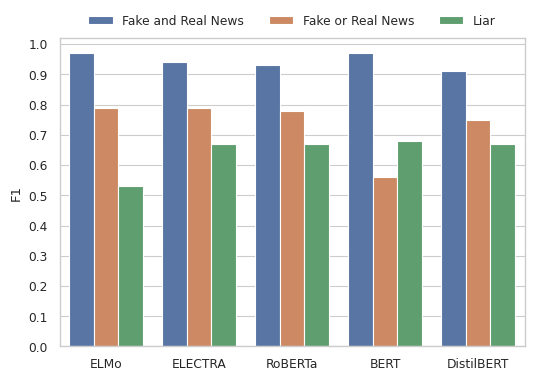

In [20]:
sns.set_style("whitegrid")
sns.set_context('paper')

plt.figure(figsize=(6, 4))

ax = sns.barplot(x=x_values, y=y_values, hue=hue_values, palette="deep")
sns.move_legend(ax, "lower center", 
    bbox_to_anchor=(.5, 1), ncol=4, title=None, frameon=False)

ax.set_yticks(list(np.arange(0,1.1,0.1)))
plt.ylabel('F1')

plt.savefig('pipeline/text-based/results/figures/baseline_validation.png')

### Visualisation on **test** set

In [21]:
# Concat inference results ELMo with other models
path_to_json_results = "pipeline/text-based/results/json"

performance = {}
for file_name in os.listdir(path_to_json_results):
    path = os.path.join(path_to_json_results, file_name)
    with open(path) as f:
        json_results = json.load(f)
        performance.update(json_results)

In [26]:
# F1 table only

index = json_results.keys()
values = []
cols = []

for model_name, d in json_results.items():
    tmp_cols = []

    for dataset, scores in d.items():
        for metric, score in scores.items():
            if metric == 'f1':
                values.append(score)
                tmp_cols.append((dataset, metric))

cols.append(tmp_cols)

# Flatten columns
cols = sum(cols, [])

multi_index = pd.MultiIndex.from_tuples(cols)

# Reshape the values
reshaped_values = np.array(values).reshape(-1, len(index))  

df = pd.DataFrame(reshaped_values, index=multi_index, columns=index)
df.T

,kaggle_1000,fake_real_1000,liar_1000
,f1,f1,f1
bert-base-uncased,1.000000,0.666667,1.000000
roberta-base,0.800000,0.666667,1.000000
distilbert-base-uncased,0.888889,1.000000,0.666667
google/electra-base-discriminator,1.000000,0.800000,0.888889


In [27]:
# Full table (A, P, R, F1)
# Create table with 2 level index (dataset, metric), columns are the models, values are the scores

index = performance.keys()
values, cols = [], [] # For table

x_values, y_values, hue_values = [], [], [] # For chart

for model_name, d in performance.items():
    tmp_cols = []
    for dataset, scores in d.items():
        for metric, score in scores.items():
            # Table
            values.append(score)
            tmp_cols.append((dataset, metric))

cols.append(tmp_cols)

# Flatten columns
cols = sum(cols, [])

multi_index = pd.MultiIndex.from_tuples(cols)

# Reshape the values
reshaped_values = np.array(values).reshape(-1, len(index))  

# TABLE
df = pd.DataFrame(reshaped_values, index=multi_index, columns=index)
df.T

kaggle_1000                             \
                                     accuracy precision recall        f1   
elmo                                 0.800000  0.666667    1.0  1.000000   
bert-base-uncased                    1.000000  1.000000    1.0  0.800000   
roberta-base                         0.666667  0.800000    1.0  0.666667   
distilbert-base-uncased              0.800000  1.000000    1.0  1.000000   
google/electra-base-discriminator    0.800000  1.000000    1.0  0.800000   

                                  fake_real_1000                      \
                                        accuracy precision    recall   
elmo                                    0.800000       1.0  1.000000   
bert-base-uncased                       0.800000       1.0  0.666667   
roberta-base                            1.000000       1.0  0.600000   
distilbert-base-uncased                 0.888889       0.6  1.000000   
google/electra-base-discriminator       1.000000       0.5  0.500000   

                                            liar_1000                   \
                                         f1  accuracy precision recall   
elmo                               0.666667  0.800000       1.0    1.0   
bert-base-uncased                  1.000000  0.666667       1.0    1.0   
roberta-base                       1.000000  1.000000       1.0    0.6   
distilbert-base-uncased            1.000000  0.800000       1.0    0.5   
google/electra-base-discriminator  1.000000  1.000000       1.0    1.0   

                                             
                                         f1  
elmo                               0.666667  
bert-base-uncased                  0.800000  
roberta-base                       0.800000  
distilbert-base-uncased            1.000000  
google/electra-base-discriminator  0.888889

In [28]:
# For chart
x_values, y_values, hue_values = [], [], [] # For chart

for model_name, d in performance.items():
    for dataset, scores in d.items():
        x_values.append(models[model_name])
        hue_values.append(datasets[dataset])
        y_values.append(d[dataset]['f1'])

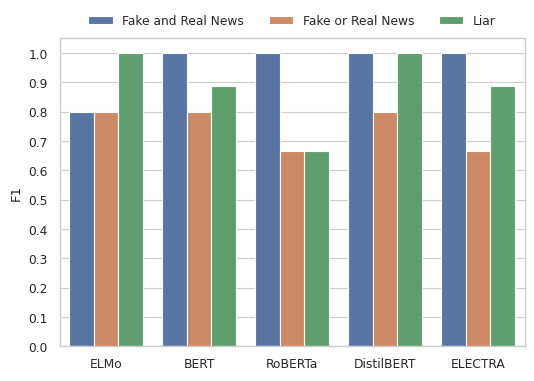

In [29]:
# Chart
sns.set_style("whitegrid")
sns.set_context('paper')

plt.figure(figsize=(6, 4))

ax = sns.barplot(x=x_values, y=y_values, hue=hue_values, palette="deep")
sns.move_legend(ax, "lower center", 
    bbox_to_anchor=(.5, 1), ncol=4, title=None, frameon=False)

ax.set_yticks(list(np.arange(0,1.1,0.1)))
plt.ylabel('F1')

plt.savefig('pipeline/text-based/results/figures/baseline_test.png')